In [1]:
from two_stream_loader import *

In [2]:
from torch.nn.functional import softmax

In [3]:
import matplotlib.pyplot as plt

In [177]:
# path_temporal = r"/mnt/disks/datastorage/videos/elp/demos/flownet2/"
# path_spatial = r"/mnt/disks/datastorage/videos/elp/demos/rgb/"

path_temporal = r"/mnt/disks/datastorage/videos/flownet2/"
path_spatial = r"/mnt/disks/datastorage/videos/rgb/"

# path_temporal = r"/mnt/disks/datastorage/videos/elp/test/flownet2/"
# path_spatial = r"/mnt/disks/datastorage/videos/elp/test/rgb/"

#file = "v_Assault_g17_c000003"
#file = "v_Shooting_g18_c000002"
#file = "v_Theft_g16_c000004"
# file = "v_Misc_g17_c000006"

file = "v_Shooting_g08_c000004"

imgs_u,imgs_v = load_temporal_images(path_temporal,file)
imgs_spatial = load_spatial_images(path_spatial,file)

imgs_normal = load_normal_spatial_images(path_spatial,file)
imgs_u_normal,imgs_v_normal = load_normal_temporal_images(path_temporal,file)

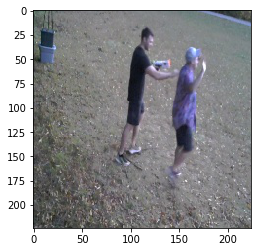

In [178]:
plt.imshow(imgs_normal[3])

In [179]:
[temporal_net,spatial_net] =load_models(path_spatial,path_temporal)

Dropout is  0
Dropout is  0


In [180]:
def stack_op(imgs_u,imgs_v,i):
    _, img_rows, img_cols = imgs_u[0].shape
    flow = torch.FloatTensor(2*10,img_rows,img_cols)

    for j in range(i, 10+i):
        H = imgs_u[j]
        V = imgs_v[j]

        flow[2*(j-1-i),:,:] = H
        flow[2*(j-1-i)+1,:,:] = V

    flow = flow.unsqueeze(0)
    
    return flow

In [181]:
if 0:
    spatial_net.eval()
    for i in imgs_spatial:
        pred=spatial_net.forward(i.unsqueeze(0)).detach().numpy().squeeze()
        print(spatial_net.forward(i.unsqueeze(0)).detach().numpy().squeeze()," Predict ",pred.argmax())

In [182]:
if 0:
    temporal_net.eval()
    for i in range(len(imgs_u)-10):
        flow = stack_op(imgs_u,imgs_v,i)
        pred = temporal_net.forward(flow).detach().numpy().squeeze()
        print(pred," Predict ",pred.argmax())
    #     print(temporal_net.forward(flow).argmax(1))

In [183]:
# global_max_u = np.abs(torch.stack(imgs_u).numpy().ravel()).max()
# global_max_v = np.abs(torch.stack(imgs_v).numpy().ravel()).max()
# print(global_max_u)
# print(global_max_v)

In [184]:
import pickle

In [185]:
# Load from file
model_pickle_name = "/home/mlp/two-stream-action-recognition/svm_model2.pkl"
with open(model_pickle_name, 'rb') as file:
    svm_model = pickle.load(file)

In [186]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

In [187]:
def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

In [188]:
g = adjust_gamma(imgs_normal[0].copy(),.3)

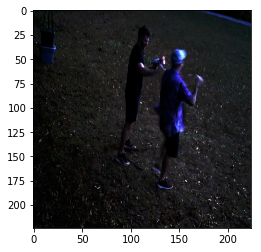

In [189]:
plt.imshow(g)

In [191]:
from IPython.display import clear_output

temporal_net.eval()
spatial_net.eval()

action_dict = {
    0: 'Theft',
    1: 'Assault',
    2: 'Shooting',
    3: 'No Action',
}


out = cv2.VideoWriter("demo.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20.0, (1344,896), True)

for i in range(len(imgs_spatial)-10):
    rgb = imgs_spatial[i]
    spatial_preds = softmax(spatial_net.forward(rgb.unsqueeze(0).cuda()),1)

    flow = stack_op(imgs_u, imgs_v, i)
    temporal_preds = softmax(temporal_net.forward(flow.cuda()),1)
    
    #preds = torch.mean(torch.cat((spatial_preds,temporal_preds)),0)#torch.mean(spatial_preds + temporal_preds,0)
    #preds = spatial_preds.squeeze()
    #p = softmax((spatial_preds + temporal_preds).cpu().detach()).numpy().squeeze()
    p = np.hstack((spatial_preds.cpu().detach().numpy().squeeze(),temporal_preds.cpu().detach().numpy().squeeze()))
    p = svm_model.predict_proba(np.expand_dims(p,0))
    
    label = action_dict[p.argmax().item()]
    
    rgb = imgs_normal[i].copy()
    rgb = adjust_gamma(imgs_normal[i].copy(),.3)
    
    flow_u = np.abs(np.tile(imgs_u[i].numpy().copy(), (3, 1, 1)).transpose(1,2,0)*255)
    flow_v = np.abs(np.tile(imgs_v[i].numpy().copy(), (3, 1, 1)).transpose(1,2,0)*255)
    
#     print(np.unique(flow_u.ravel()))
    flow_u = flow_u/flow_u.max()#global_max_u
    flow_v = flow_v/flow_v.max()#global_max_v
    
    plt.bar(np.arange(0,4),spatial_preds.cpu().detach().numpy().reshape((-1,)),tick_label=list(action_dict.values()))
    plt.title("Spatial")
    plt.savefig("SpatialBar.jpg")
    spatial_bar = plt.imread("SpatialBar.jpg")
    spatial_bar = cv2.resize(spatial_bar,(224,224))/255
    plt.close()
    
    plt.bar(np.arange(0,4),temporal_preds.cpu().detach().numpy().reshape((-1,)),tick_label=list(action_dict.values()))
    plt.title("Temporal")
    plt.savefig("TemporalBar.jpg")
    temporal_bar = plt.imread("TemporalBar.jpg")
    temporal_bar = cv2.resize(temporal_bar,(224,224))/255
    plt.close()
    
    plt.bar(np.arange(0,4),p.squeeze(),tick_label=list(action_dict.values()))
    plt.title("Combined")
    plt.savefig("CombinedBar.jpg")
    combined_bar = plt.imread("CombinedBar.jpg")
    combined_bar = cv2.resize(combined_bar,(224,224))/255
    plt.close()
    
    frame1 = np.hstack((rgb/255, flow_u, flow_v))
    frame2 = np.hstack((combined_bar,spatial_bar,temporal_bar))
    frame = np.vstack((frame1,frame2))
    
    cv2.putText(
        frame,
        label,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.75,
        (1, 1, 1),
        thickness=2
    )
    frame = cv2.resize(frame, (0, 0), fx=2, fy=2)
    frame = np.uint8(frame * 255)
    out.write(frame)
    
#     plt.figure(1,figsize = (30,30)) # creates a figure 10 inches by 10 inches
#     plt.axis('off')
#     plt.imshow(frame)
#     plt.show()
#     clear_output(wait=True)
#     if i > 15:
#         break
#     print(i)
out.release()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
cap = cv2.VideoCapture('demo.mp4')

if cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Frame', frame)

In [ ]:
plt.figure(figsize=(20,50))
plt.imshow(np.uint8(frame*255))

In [ ]:
for i in range(len(imgs_spatial)-10):
    rgb = imgs_spatial[i]
    spatial_preds = softmax(spatial_net.forward(rgb.unsqueeze(0)))
#     print(spatial_preds.detach().numpy())

    flow = stack_op(imgs_u, imgs_v, i)
    temporal_preds = softmax(temporal_net.forward(flow))
#     print(temporal_preds.detach().numpy())
    
    preds = torch.mean(spatial_preds + temporal_preds,0)
    label = action_dict[preds.argmax().item()]
#     print(label)  
#     print(np.mean(spatial_preds.detach().numpy()+temporal_preds.detach().numpy(),0))
    frame = imgs_normal[i].copy()
    cv2.putText(
        frame,
        label,
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        thickness=3
    )
    
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    clear_output(wait=True)